# Git clone GCNN library

In [1]:
# Git clone gcnn and setup lib
! git clone https://github.com/tscohen/GrouPy.git
! cp -r GrouPy/* .
! ls
! python setup.py install
! rm -rf GrouPy/

Cloning into 'GrouPy'...
remote: Enumerating objects: 221, done.
remote: Total 221 (delta 0), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (221/221), 167.17 KiB | 2.46 MiB/s, done.
Resolving deltas: 100% (112/112), done.
groupy	LICENSE      p4_fmaps.png   README.md	      sample_data
GrouPy	p4_anim.gif  p4m_fmaps.png  requirements.txt  setup.py
running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/groupy
copying groupy/__init__.py -> build/lib.linux-x86_64-2.7/groupy
creating build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/C4_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/Z3_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/O_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/test_garray.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/D4_array.py -> build/lib.linux-x86_64-2.7/groupy

# Import necessary package

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import datetime
import math
from random import randint

# GCNN library
from groupy.gconv.tensorflow_gconv.splitgconv2d import gconv2d, gconv2d_util

print(tf.__version__)

1.12.0-rc1


# Import dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


# Nomalize all the data between 0 - 1 and reshape the data shape

In [0]:
train_images = train_images / 255.0
train_images = np.reshape(train_images, (-1,28,28,1))
train_images = np.concatenate((train_images, train_images, train_images), axis=3)
test_images = test_images / 255.0
test_images = np.reshape(test_images, (-1,28,28,1))
test_images = np.concatenate((test_images, test_images, test_images), axis=3)


# Try to print the image and shape of data

In [0]:
# Labels array
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
print'Train data shape: ', train_images.shape
print'Train labels shape: ', train_labels.shape
print'Test data shape: ', test_images.shape
print'Test labels shape: ', test_labels.shape

Train data shape:  (60000, 28, 28, 3)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28, 3)
Test labels shape:  (10000,)


In [7]:
print(tf.shape(train_images[0][:,:][1]))
print(tf.shape(train_images[0][:,:,1]))
print(tf.shape(train_images[0,:,:,1]))
print(train_images[0][:,:])

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


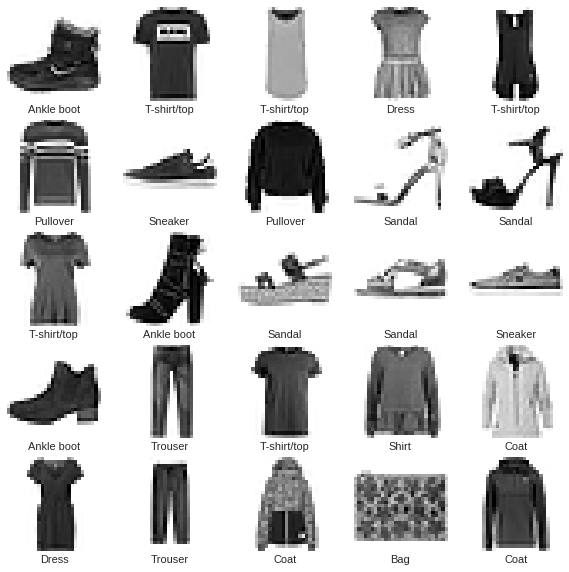

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

# Define global variable

In [0]:
# Record gcnn accuracy and the best model path
gcnn_a = []
best_gcnn_model_path = ''

# Record cnn accuracy and the best model path
cnn_a = []
best_cnn_model_path = ''

In [0]:
# Define global variable
MODEL_TYPE = 'gcnn'

# Initail model folder and some global variable
model_path = ''

if MODEL_TYPE == 'cnn':
    model_path = './model-densenet-cnn'
    cnn_a = []
    best_cnn_model_path = ''
else:
    model_path = './model-densenet-gcnn'
    gcnn_a = []
    best_gcnn_model_path = ''

shutil.rmtree(model_path, ignore_errors=True)
os.makedirs(model_path)

In [0]:
# Define static variable
IMG_SIZE_HEIGHT = 28
IMG_SIZE_WIDTH = 28
NUM_CLASSES = 10
INIT_LEARNING_RATE = 0.02
CHANGE_IN_LEARNING_RATE = 0.5
NUM_STEPS = 500
DISPLAY_STEPS = 100
NUM_OF_EPOCH = 5
OVER_BEST_EPOCH_LIMIT = 2
BATCH_SIZE = 1024
TESTING_BATCH_SIZE = 3000

# Define placeholder
features_placeholder = tf.placeholder(tf.float32, [None, IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3],
                                      name='features_placeholder')
labels_placeholder = tf.placeholder(tf.int32, [None,], name='labels_placeholder')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Due to GPU resource, separate several batch
split_factor = int(math.ceil(float(test_labels.size) / TESTING_BATCH_SIZE))
test_images_batch = np.array(np.array_split(test_images, split_factor))
test_labels_batch = np.array(np.array_split(test_labels, split_factor))

# Get mini batch

In [0]:
def next_batch(start_index, end_index, idx):

    if end_index > train_labels.size:
        pro_idx = np.arange(0, train_labels.size)
        np.random.shuffle(pro_idx)
        idx = np.concatenate((idx,pro_idx))  
        
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        
        # remove end_index of idx
        idx = pro_idx
        
        return train_features_shuffle, train_labels_shuffle, True, idx
    else:
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        return train_features_shuffle, train_labels_shuffle, False, idx
  
  
def extract_mini_batch(start_index, end_index, idx):
  
    # Extract batch size of features and labels by idx
    train_features_shuffle = [train_images[idx[i]] for i in range(start_index,end_index)]
    train_labels_shuffle = [train_labels[idx[i]] for i in range(start_index,end_index)]
    
    # Change the array to np array
    train_features_shuffle = np.array(train_features_shuffle)
    train_labels_shuffle = np.array(train_labels_shuffle)
    return train_features_shuffle, train_labels_shuffle


# Denfine convolution layer, pooling layer, batch nomlization method

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

  
def channels(x):
    return int(x.get_shape()[-1])

  
def batch_normalization(x):
    print "Batch Norm"
    eps = 1e-5
    gamma = tf.Variable(tf.constant(1.0, shape=[channels(x)]))
    beta = tf.Variable(tf.constant(0.0, shape=[channels(x)]))
    mean, variance = tf.nn.moments(x, [0, 1, 2], keep_dims=False)
    return tf.nn.batch_normalization(x, mean, variance, beta, gamma, eps)
  
  
def tf_conv2d_layer(features, num_filters, filter_size, strides, padding):
    
    # Define filter size and strides
    filter_height, filter_width = filter_size
    stride_height, stride_width = strides

    # Create weight and bias variable
    weight = weight_variable([filter_height, filter_width, features.get_shape().as_list()[3], num_filters])
    bias = bias_variable([num_filters])
    tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    conv = tf.nn.conv2d(features, weight, strides=[1, stride_height, stride_width, 1], padding=padding)

    # Add bias
    y = tf.nn.bias_add(conv, bias)
    
    # Batch normalization before activation function
    y = batch_normalization(y)
    
    # Reture a non-linear conv layer
    return tf.nn.relu(y)




def tf_max_pool2d_layer(features, pool_size, strides, padding):
    # Define pooling size
    pool_height, pool_width = pool_size
    stride_height, stride_width = strides

    # Create max pool layer
    max_pool_layer = tf.nn.max_pool(
        features,
        ksize=[1, pool_height, pool_width, 1],
        strides=[1, stride_height, stride_width, 1],
        padding=padding)

    return max_pool_layer


def tf_dense_layer(features, units, activation=None):
    # Create weight and bias variable
    weight = weight_variable([features.get_shape().as_list()[1], units])
    bias = bias_variable([units])
    tf.add_to_collection('loss', weight)

    y = tf.nn.bias_add(tf.matmul(features, weight), bias)

    if activation == 'relu':
        return tf.nn.relu(y)
    elif activation == 'softmax':
        return tf.nn.softmax(y)
    else:
        return y

# Define Group Convolution Layer

In [0]:

def tf_gconv2d_layer(features, channels_in_out, filter_size, strides, padding, h_in_out):

    # Define filter size and strides
    h_input, h_output = h_in_out
    in_channels, out_channels = channels_in_out
    stride_height, stride_width = strides

    gconv_indices, gconv_shape_info, w_shape = gconv2d_util(
        h_input=h_input, h_output=h_output, in_channels=in_channels, out_channels=out_channels, ksize=filter_size)

    # Create weight and bias variable
    weight = weight_variable(w_shape)
    tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    gconv = gconv2d(input=features, filter=weight, strides=[1, stride_height, stride_width, 1], padding=padding,
                gconv_indices=gconv_indices, gconv_shape_info=gconv_shape_info)

    # Add bias
    bias = bias_variable([gconv.get_shape().as_list()[3]])
    y = tf.nn.bias_add(gconv, bias)
    
    # Batch normalization before activation function
    y = batch_normalization(y)
    
    # Reture a non-linear conv layer
    return tf.nn.relu(y)

# Define convolution network structure

In [0]:
def conv_net(features, n_classes):

  if MODEL_TYPE == 'gcnn':
    
    with tf.name_scope("layer1"):
        gconv_layer1 = tf_gconv2d_layer(
            features=tf.convert_to_tensor(features),
            channels_in_out=(3, 4 ),
            filter_size=5,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('Z2', 'D4'))
        #gconv_layer1 = tf.identity(tf.nn.dropout(gconv_layer1, 0.25))
        print 'layer 1: {}'.format(gconv_layer1.get_shape())
        
    with tf.name_scope("layer2"):
        pool_layer2 = tf_max_pool2d_layer(
            features=gconv_layer1,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 2: {}'.format(pool_layer2.get_shape())
    
    with tf.name_scope("layer3"):
        gconv_layer3 = tf_gconv2d_layer(
            features=pool_layer2,
            channels_in_out=(pool_layer2.get_shape().as_list()[3] / 8, 8),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('D4', 'D4'))
        print 'layer 3: {}'.format(gconv_layer3.get_shape())
    
    with tf.name_scope("layer4"):
        pool_layer4 = tf_max_pool2d_layer(
            features=gconv_layer3,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 4: {}'.format(pool_layer4.get_shape())
        
    
    with tf.name_scope("layer5"):
        gconv_layer5 = tf_gconv2d_layer(
            features=pool_layer4,
            channels_in_out=(pool_layer4.get_shape().as_list()[3] / 8, 16),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('D4', 'D4'))
        print 'layer 5: {}'.format(gconv_layer5.get_shape())

    with tf.name_scope("layer6"):
        pool_layer6 = tf_max_pool2d_layer(
            features=gconv_layer5,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 6: {}'.format(pool_layer6.get_shape())

        
    with tf.name_scope("layer7"):
        pool_shape_list = pool_layer6.get_shape().as_list()
        flat_layer7 = tf.reshape(
            pool_layer6,
            shape=[-1, pool_shape_list[1] * pool_shape_list[2] * pool_shape_list[3]])
        print 'layer 7: {}'.format(flat_layer7.get_shape())
    
    # Go to fully connected layer
    with tf.name_scope("layer8"):
        dens_layer8 = tf_dense_layer(
            features=flat_layer7,
            units=128)
        dens_layer8 = tf.identity(tf.nn.dropout(dens_layer8, 0.6))
        print 'layer 8: {}'.format(dens_layer8.get_shape())
    
    
    with tf.name_scope("layer9"):
        dens_layer9 = tf_dense_layer(
            features=dens_layer8,
            units=n_classes)
    
        print 'layer 9: {}'.format(dens_layer9.get_shape())
    
    return dens_layer9
    
  else:
    
    with tf.name_scope("layer1"):
        gconv_layer1 = tf_conv2d_layer(
            features=tf.convert_to_tensor(features),
            num_filters=32,
            filter_size=(5, 5),
            strides=(1, 1),
            padding='SAME')
        print 'layer 1: {}'.format(gconv_layer1.get_shape())
           
    with tf.name_scope("layer2"):
        pool_layer2 = tf_max_pool2d_layer(
            features=gconv_layer1,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 2: {}'.format(pool_layer2.get_shape())

    with tf.name_scope("layer3"):
        gconv_layer3 = tf_conv2d_layer(
            features=pool_layer2,
            num_filters=64,
            filter_size=(3, 3),
            strides=(1, 1),
            padding='SAME')
        print 'layer 3: {}'.format(gconv_layer3.get_shape())

    with tf.name_scope("layer4"):
        pool_layer4 = tf_max_pool2d_layer(
            features=gconv_layer3,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 4: {}'.format(pool_layer4.get_shape())
        
    with tf.name_scope("layer5"):
        gconv_layer5 = tf_conv2d_layer(
            features=pool_layer4,
            num_filters=128,
            filter_size=(2, 2),
            strides=(1, 1),
            padding='SAME')
        print 'layer 5: {}'.format(gconv_layer5.get_shape())

    with tf.name_scope("layer6"):
        pool_layer6 = tf_max_pool2d_layer(
            features=gconv_layer5,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 6: {}'.format(pool_layer6.get_shape())
        
    with tf.name_scope("layer7"):
        pool_shape_list = pool_layer6.get_shape().as_list()
        flat_layer7 = tf.reshape(
            pool_layer6,
            shape=[-1, pool_shape_list[1] * pool_shape_list[2] * pool_shape_list[3]])
        print 'layer 7: {}'.format(flat_layer7.get_shape())
    
    # Go to fully connected layer
    with tf.name_scope("layer8"):
        dens_layer8 = tf_dense_layer(
            features=flat_layer7,
            units=128)
        dens_layer8 = tf.identity(tf.nn.dropout(dens_layer8, 0.6))
        print 'layer 8: {}'.format(dens_layer8.get_shape())
    
    
    with tf.name_scope("layer9"):
        dens_layer9 = tf_dense_layer(
            features=dens_layer8,
            units=n_classes)
    
        print 'layer 9: {}'.format(dens_layer9.get_shape())
    
    
    return dens_layer9


# Training with CNN and GCNN
Remember everytime start training, please run the part of "Define global variable" to initial some record and modify the MODEL_TYPE

In [0]:
# Construct model
logits = conv_net(features_placeholder, NUM_CLASSES)

# Define loss and optimizer
with tf.name_scope("cost"):
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels_placeholder, dtype=tf.int32)))
    
    # L2
    weight_list = tf.get_collection('loss')
    total_l2_loss = 0.0
    for i in range(len(weight_list)):
        total_l2_loss += tf.nn.l2_loss(weight_list[i])
      
    loss_l2 = loss_op + 0.001 * total_l2_loss
    
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_l2,
                                  global_step=tf.train.get_global_step())

# Contruct prediction model for evaluation
with tf.name_scope("accuracy"):
    prediction = tf.nn.softmax(logits, name='prediction')
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.cast(labels_placeholder, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
# Start training
with tf.Session() as sess:
   
    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # For future retore the model (Session bundle) to predict image
    saver = tf.train.Saver()

    # Start time
    start_ts = datetime.datetime.now()
    
    # For early stopping
    best_loss = float('inf')
    
    epoch_learning_rate = INIT_LEARNING_RATE
    for epoch in range(NUM_OF_EPOCH):
        
        epoch_learning_rate *= CHANGE_IN_LEARNING_RATE
        print '\n==============Epoch {} start (learning rate: {})================'.format(epoch, epoch_learning_rate)
        
        step_loss = 0.0
        start_index = 0
        end_index = start_index + BATCH_SIZE
        idx = np.arange(0 , train_labels.size)
        np.random.shuffle(idx)
    
        for step in range(1, NUM_STEPS + 1):

            train_features_shuffle, train_labels_shuffle, reset, idx_new = next_batch(
                start_index,
                end_index,
                idx)
          
            idx = idx_new
            if reset:
                start_index = 0
                end_index = start_index + BATCH_SIZE
            else:
                # Increase the start and end index
                start_index += BATCH_SIZE
                end_index += BATCH_SIZE
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={
                features_placeholder: train_features_shuffle,
                labels_placeholder: train_labels_shuffle,
                learning_rate: epoch_learning_rate})

            # Every x step print the summary
            if step % DISPLAY_STEPS == 0 or step == 1:

                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy],
                                              feed_dict={features_placeholder: train_features_shuffle,
                                                         labels_placeholder: train_labels_shuffle,
                                                         learning_rate: epoch_learning_rate})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc) + ", Time= " + \
                      "{}s".format((datetime.datetime.now() - start_ts).total_seconds()))
              
                # Calculate full set testing accuracy (Due to GPU resource, separate several segment)
                total_test_accuracy = 0.0
                
                for i in range(split_factor):
                  total_test_accuracy += sess.run(accuracy, feed_dict={features_placeholder: test_images_batch[i],
                                                      labels_placeholder: test_labels_batch[i],
                                                      learning_rate: epoch_learning_rate})
                test_acc = total_test_accuracy/split_factor
                print "Testing Accuracy: {}".format(test_acc) 
                
                # Record each display accuracy for plot graph
                if not (epoch == 0 and step == 1):
                    if MODEL_TYPE == 'cnn':
                        cnn_a.append(test_acc)
                    else:
                        gcnn_a.append(test_acc)

                start_ts = datetime.datetime.now()
                
                # Training early stop 
                if loss < best_loss:
                  
                    # We can restore the varable to check the content
                    save_path = saver.save(sess, model_path + '/model/epoch-' + str(epoch))
                    print("Model saved in file: {}, Step: {}".format(save_path, step))
                    
                    best_loss = loss
                    
                    if MODEL_TYPE == 'cnn':
                        best_cnn_model_path = save_path
                    else:
                        best_gcnn_model_path = save_path
                
                print '\n'
    print 'Finish training!'

# Training log with CNN


Batch Norm

layer 1: (?, 28, 28, 32)

layer 2: (?, 14, 14, 32)

Batch Norm

layer 3: (?, 14, 14, 64)

layer 4: (?, 7, 7, 64)

Batch Norm

layer 5: (?, 7, 7, 128)

layer 6: (?, 4, 4, 128)

layer 7: (?, 2048)

layer 8: (?, 128)

layer 9: (?, 10)

<br>

==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 6.2336, Training Accuracy= 0.143, Time= 1.047673s
Testing Accuracy: 0.130099998787

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 1


Step 100, Minibatch Loss= 1.2047, Training Accuracy= 0.666, Time= 15.260767s
Testing Accuracy: 0.659199997783

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 100


Step 200, Minibatch Loss= 0.7602, Training Accuracy= 0.756, Time= 15.324634s
Testing Accuracy: 0.747000008821

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 200


Step 300, Minibatch Loss= 0.5260, Training Accuracy= 0.800, Time= 15.505832s
Testing Accuracy: 0.797399997711

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 300


Step 400, Minibatch Loss= 0.3694, Training Accuracy= 0.872, Time= 15.280299s
Testing Accuracy: 0.826300010085

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 400


Step 500, Minibatch Loss= 0.3044, Training Accuracy= 0.898, Time= 15.172976s
Testing Accuracy: 0.855200007558

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 500

<br>

==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 0.2962, Training Accuracy= 0.895, Time= 0.763726s
Testing Accuracy: 0.867600008845

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 1


Step 100, Minibatch Loss= 0.2367, Training Accuracy= 0.917, Time= 15.254041s
Testing Accuracy: 0.884800001979

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 100


Step 200, Minibatch Loss= 0.2536, Training Accuracy= 0.916, Time= 15.255066s
Testing Accuracy: 0.881100013852


Step 300, Minibatch Loss= 0.2285, Training Accuracy= 0.910, Time= 15.002262s
Testing Accuracy: 0.892899990082

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 300


Step 400, Minibatch Loss= 0.2304, Training Accuracy= 0.907, Time= 15.219568s
Testing Accuracy: 0.879999995232


Step 500, Minibatch Loss= 0.1968, Training Accuracy= 0.931, Time= 14.594608s
Testing Accuracy: 0.885900005698

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 500

<br>

==============Epoch 2 start (learning rate: 0.0025)================

Step 1, Minibatch Loss= 0.2131, Training Accuracy= 0.925, Time= 0.998448s
Testing Accuracy: 0.898699998856


Step 100, Minibatch Loss= 0.1629, Training Accuracy= 0.941, Time= 14.377939s
Testing Accuracy: 0.904100000858

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 100


Step 200, Minibatch Loss= 0.1688, Training Accuracy= 0.938, Time= 15.123207s
Testing Accuracy: 0.899599984288


Step 300, Minibatch Loss= 0.1544, Training Accuracy= 0.944, Time= 14.589256s
Testing Accuracy: 0.88820001483

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 300


Step 400, Minibatch Loss= 0.1562, Training Accuracy= 0.944, Time= 15.261361s
Testing Accuracy: 0.90609999001


Step 500, Minibatch Loss= 0.1349, Training Accuracy= 0.956, Time= 14.590349s
Testing Accuracy: 0.900600001216

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 500

<br>

==============Epoch 3 start (learning rate: 0.00125)================

Step 1, Minibatch Loss= 0.1450, Training Accuracy= 0.950, Time= 1.00269s
Testing Accuracy: 0.905100002885


Step 100, Minibatch Loss= 0.1432, Training Accuracy= 0.959, Time= 14.385966s
Testing Accuracy: 0.902499988675


Step 200, Minibatch Loss= 0.1215, Training Accuracy= 0.964, Time= 14.625902s
Testing Accuracy: 0.908500000834

Model saved in file: ./model-densenet-cnn/model/epoch-3, Step: 200


Step 300, Minibatch Loss= 0.1273, Training Accuracy= 0.952, Time= 15.190188s
Testing Accuracy: 0.900300011039


Step 400, Minibatch Loss= 0.1453, Training Accuracy= 0.948, Time= 14.514123s
Testing Accuracy: 0.905299991369


Step 500, Minibatch Loss= 0.1082, Training Accuracy= 0.968, Time= 14.594287s
Testing Accuracy: 0.909900009632

Model saved in file: ./model-densenet-cnn/model/epoch-3, Step: 500

<br>

==============Epoch 4 start (learning rate: 0.000625)================

Step 1, Minibatch Loss= 0.0980, Training Accuracy= 0.976, Time= 0.786954s
Testing Accuracy: 0.910100013018

Model saved in file: ./model-densenet-cnn/model/epoch-4, Step: 1


Step 100, Minibatch Loss= 0.0956, Training Accuracy= 0.979, Time= 15.109789s
Testing Accuracy: 0.909799993038

Model saved in file: ./model-densenet-cnn/model/epoch-4, Step: 100


Step 200, Minibatch Loss= 0.0956, Training Accuracy= 0.974, Time= 15.087434s
Testing Accuracy: 0.911099985242


Step 300, Minibatch Loss= 0.0814, Training Accuracy= 0.971, Time= 14.509392s
Testing Accuracy: 0.906199991703

Model saved in file: ./model-densenet-cnn/model/epoch-4, Step: 300


Step 400, Minibatch Loss= 0.0873, Training Accuracy= 0.975, Time= 15.198866s
Testing Accuracy: 0.908800005913


Step 500, Minibatch Loss= 0.0771, Training Accuracy= 0.977, Time= 14.568063s
Testing Accuracy: 0.91060000658

Model saved in file: ./model-densenet-cnn/model/epoch-4, Step: 500


Finish training!

# Training log with GCNN

Batch Norm

layer 1: (?, 28, 28, 32)

layer 2: (?, 14, 14, 32)

Batch Norm

layer 3: (?, 14, 14, 64)

layer 4: (?, 7, 7, 64)

Batch Norm

layer 5: (?, 7, 7, 128)

layer 6: (?, 4, 4, 128)

layer 7: (?, 2048)

layer 8: (?, 128)

layer 9: (?, 10)

<br>
==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 5.2308, Training Accuracy= 0.139, Time= 0.780502s
Testing Accuracy: 0.141499999911

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 1


Step 100, Minibatch Loss= 3.1848, Training Accuracy= 0.421, Time= 15.14713s
Testing Accuracy: 0.399499997497

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 100


Step 200, Minibatch Loss= 0.5795, Training Accuracy= 0.779, Time= 15.031467s
Testing Accuracy: 0.769199997187

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 200


Step 300, Minibatch Loss= 0.4434, Training Accuracy= 0.844, Time= 15.008355s
Testing Accuracy: 0.82349999249

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 300


Step 400, Minibatch Loss= 0.3600, Training Accuracy= 0.870, Time= 15.002424s
Testing Accuracy: 0.85680000484

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 400


Step 500, Minibatch Loss= 0.3318, Training Accuracy= 0.885, Time= 15.214307s
Testing Accuracy: 0.863600000739

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 500

<br>

==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 0.3630, Training Accuracy= 0.872, Time= 0.598826s
Testing Accuracy: 0.870800003409


Step 100, Minibatch Loss= 0.2309, Training Accuracy= 0.922, Time= 14.55542s
Testing Accuracy: 0.886899992824

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 100


Step 200, Minibatch Loss= 0.2904, Training Accuracy= 0.901, Time= 15.007127s
Testing Accuracy: 0.873400002718


Step 300, Minibatch Loss= 0.2777, Training Accuracy= 0.901, Time= 14.710842s
Testing Accuracy: 0.870799988508


Step 400, Minibatch Loss= 0.2498, Training Accuracy= 0.903, Time= 14.658346s
Testing Accuracy: 0.894300013781


Step 500, Minibatch Loss= 0.2110, Training Accuracy= 0.920, Time= 14.731112s
Testing Accuracy: 0.891099989414

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 500

<br>

==============Epoch 2 start (learning rate: 0.0025)================

Step 1, Minibatch Loss= 0.1823, Training Accuracy= 0.937, Time= 0.608337s
Testing Accuracy: 0.90000000596

Model saved in file: ./model-densenet-gcnn/model/epoch-2, Step: 1


Step 100, Minibatch Loss= 0.2003, Training Accuracy= 0.926, Time= 14.981216s
Testing Accuracy: 0.903999984264


Step 200, Minibatch Loss= 0.2071, Training Accuracy= 0.922, Time= 14.671677s
Testing Accuracy: 0.902300000191


Step 300, Minibatch Loss= 0.1794, Training Accuracy= 0.940, Time= 14.686843s
Testing Accuracy: 0.89620000124

Model saved in file: ./model-densenet-gcnn/model/epoch-2, Step: 300


Step 400, Minibatch Loss= 0.1958, Training Accuracy= 0.934, Time= 15.335991s
Testing Accuracy: 0.904299989343


Step 500, Minibatch Loss= 0.2069, Training Accuracy= 0.927, Time= 14.727073s
Testing Accuracy: 0.893500000238

<br>

==============Epoch 3 start (learning rate: 0.00125)================

Step 1, Minibatch Loss= 0.1815, Training Accuracy= 0.931, Time= 0.198895s
Testing Accuracy: 0.912099987268


Step 100, Minibatch Loss= 0.1427, Training Accuracy= 0.954, Time= 14.582833s
Testing Accuracy: 0.909899994731

Model saved in file: ./model-densenet-gcnn/model/epoch-3, Step: 100


Step 200, Minibatch Loss= 0.1524, Training Accuracy= 0.949, Time= 15.132901s
Testing Accuracy: 0.90680000186


Step 300, Minibatch Loss= 0.1438, Training Accuracy= 0.947, Time= 14.798298s
Testing Accuracy: 0.907299995422


Step 400, Minibatch Loss= 0.1576, Training Accuracy= 0.940, Time= 14.834046s
Testing Accuracy: 0.910800009966


Step 500, Minibatch Loss= 0.1334, Training Accuracy= 0.952, Time= 14.806288s
Testing Accuracy: 0.906399995089

Model saved in file: ./model-densenet-gcnn/model/epoch-3, Step: 500

<br>

==============Epoch 4 start (learning rate: 0.000625)================

Step 1, Minibatch Loss= 0.1253, Training Accuracy= 0.963, Time= 0.604678s
Testing Accuracy: 0.913200005889

Model saved in file: ./model-densenet-gcnn/model/epoch-4, Step: 1


Step 100, Minibatch Loss= 0.1023, Training Accuracy= 0.967, Time= 15.14339s
Testing Accuracy: 0.913300007582

Model saved in file: ./model-densenet-gcnn/model/epoch-4, Step: 100


Step 200, Minibatch Loss= 0.1228, Training Accuracy= 0.956, Time= 15.185048s
Testing Accuracy: 0.914200007915


Step 300, Minibatch Loss= 0.1097, Training Accuracy= 0.965, Time= 14.688039s
Testing Accuracy: 0.909799978137


Step 400, Minibatch Loss= 0.1035, Training Accuracy= 0.968, Time= 14.717862s
Testing Accuracy: 0.914299994707


Step 500, Minibatch Loss= 0.1030, Training Accuracy= 0.971, Time= 14.734546s
Testing Accuracy: 0.911799997091


Finish training!

# Plot cnn and gcnn accuracy graph

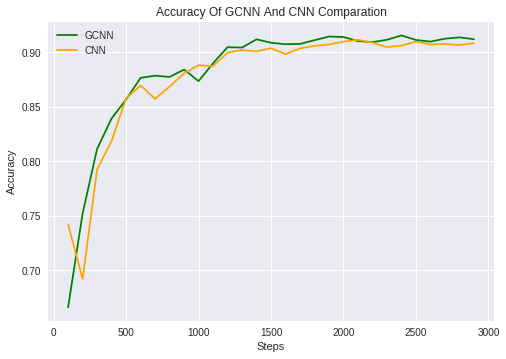

In [19]:
# This is for two type of conv have same step accuarcy record 
total_record_step = (NUM_OF_EPOCH * NUM_STEPS/DISPLAY_STEPS) + (NUM_OF_EPOCH -1)
steps = []

for i in range(total_record_step):
    steps.append((i+1)*DISPLAY_STEPS)

plt.plot(steps[:len(gcnn_a)], gcnn_a, color='g')
plt.plot(steps[:len(cnn_a)], cnn_a, color='orange')

plt.legend(['GCNN', 'CNN'])

plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Of GCNN And CNN Comparation')

plt.show()


# Define extract random predict result method 

In [0]:
def extract_predict_result(num_predict_size, extract_num, part_of_test_images, part_of_test_labels, predict_result):
    idx = np.arange(0, num_predict_size)
    np.random.shuffle(idx)  
    
    # Extract batch size of features and labels by idx
    part_of_test_images = [part_of_test_images[idx[i]] for i in range(0,extract_num)]
    part_of_test_labels = [part_of_test_labels[idx[i]] for i in range(0,extract_num)]
    predict_result = [predict_result[idx[i]] for i in range(0,extract_num)]
    
    # Change the array to np array
    part_of_test_images = np.array(part_of_test_images)
    part_of_test_labels = np.array(part_of_test_labels)
    predict_result = np.array(predict_result)
    return part_of_test_images, part_of_test_labels, predict_result

# Predict with gcnn
If you run gcnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-gcnn/model/epoch-4


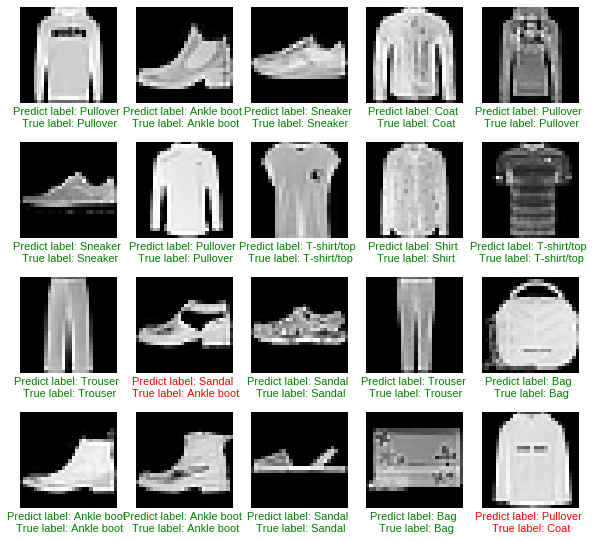

In [24]:
gcnn_graph = tf.Graph()
with tf.Session(graph=gcnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_gcnn_model_path + '.meta')
    saver.restore(sess, best_gcnn_model_path)

    graph = tf.get_default_graph()
    
    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy_1/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = class_names[predicted_label]
        true_class = class_names[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)

    


# Predict with cnn
If you run cnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-cnn/model/epoch-4


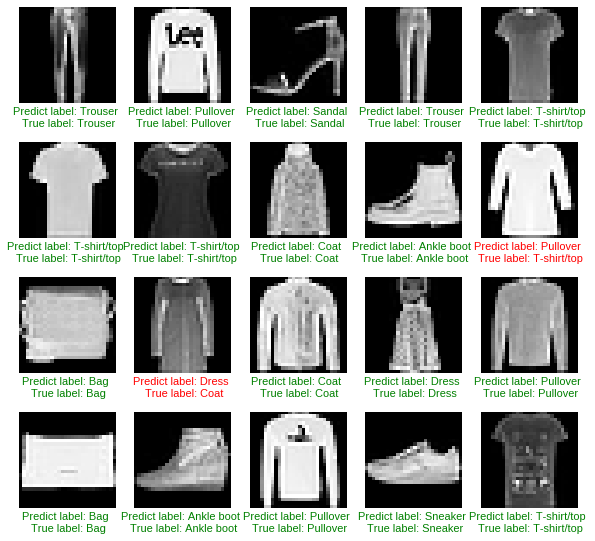

In [22]:
cnn_graph = tf.Graph()
with tf.Session(graph=cnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_cnn_model_path + '.meta')
    saver.restore(sess, best_cnn_model_path)

    graph = tf.get_default_graph()

    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = class_names[predicted_label]
        true_class = class_names[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)